# Setup

In [64]:
# Global Variables
DATASET_IMAGES_DIR = "C:/Users/agand/ObjectDetectionFiles//logistics"
CLASSES = "C:/Users/agand/ObjectDetectionFiles//logistics.names"
MODEL1_NAMES_FILE = "C:/Users/agand/ObjectDetectionFiles/yolo_model_1/logistics.names"
MODEL1_WEIGHTS = "C:/Users/agand/ObjectDetectionFiles/yolo_model_1/yolov4-tiny-logistics_size_416_1.weights"
MODEL1_CFG = "C:/Users/agand/ObjectDetectionFiles//yolo_model_1/yolov4-tiny-logistics_size_416_1.cfg"
MODEL2_NAMES_FILE = "C:/Users/agand/ObjectDetectionFiles/yolo_model_2/logistics.names"
MODEL2_WEIGHTS = "C:/Users/agand/ObjectDetectionFiles//yolo_model_2/yolov4-tiny-logistics_size_416_2.weights"
MODEL2_CFG = "C:/Users/agand/ObjectDetectionFiles//yolo_model_2/yolov4-tiny-logistics_size_416_2.cfg"
OUTPUT_DIR = "C:/Users/agand/ObjectDetectionFiles/outputs"
MODEL1_OUT = "C:/Users/agand/ObjectDetectionFiles/outputs/model1"
MODEL2_OUT = "C:/Users/agand/ObjectDetectionFiles/outputs/model2"

In [ ]:
# Import libraries
import os, glob, json
import cv2
import numpy as np
import pandas as pd

In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL1_OUT, exist_ok=True)  
os.makedirs(MODEL2_OUT, exist_ok=True)
IMAGES = glob.glob(os.path.join(DATASET_IMAGES_DIR, '*.jpg'))

# Prediction

In [ ]:
def yolo_model(cfgfile, weightfile,namesfile):
    net = cv2.dnn.readNet(weightfile,cfgfile)
    layers = net.getLayerNames()
    output_layers = [layers[i-1] for i in net.getUnconnectedOutLayers()]
    with open(namesfile, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    return net, output_layers, classes

net1, layers1, classes1 = yolo_model(MODEL1_CFG, MODEL1_WEIGHTS,MODEL1_NAMES_FILE)
net2, layers2, classes2 = yolo_model(MODEL2_CFG, MODEL2_WEIGHTS,MODEL2_NAMES_FILE)

In [ ]:
def predict_image(image_path, net, output_layers):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(
        image,
        scalefactor=1/255.0,
        size=(w,h),
        mean=(0, 0, 0),
        swapRB=True,
        crop=False
    )
    net.setInput(blob)
    outputs = net.forward(output_layers)
    detections = []
    for feature_maps in outputs:
        for detection in feature_maps:
            boxes = detection[:4].tolist()
            score = detection[4].tolist()
            class_scores = detection[5:].tolist()
            class_id = int(np.argmax(class_scores))
            detections += [{"image_path":image_path,"class_id": class_id, "score": score, "box": boxes}]
    return detections

def get_ground_truth(image_path):
    gt_txt = os.path.splitext(image_path)[0] + ".txt"
    ground_truth = []
    if not os.path.exists(gt_txt):
        return ground_truth 

    with open(gt_txt, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            ground_truth.append({
                "class_id": cls,
                "box": parts[1:5]
            })
    return ground_truth


def save_prediction_json(img_path,model,detections,output_json):
    json_data = {
        "image_path": img_path,
        "model":model,
        "predictions": detections,
        "ground_truth": get_ground_truth(img_path)
    }
    with open(output_json, 'w') as f:
        json.dump(json_data, f, indent=4)

for img_path in IMAGES:
    detections1 = predict_image(img_path, net1, layers1)
    detections2 = predict_image(img_path, net2, layers2)
    
    output_json1 = os.path.join(MODEL1_OUT, os.path.basename(img_path).replace('.jpg', '_predictions.json'))
    output_json2 = os.path.join(MODEL2_OUT, os.path.basename(img_path).replace('.jpg', '_predictions.json'))

    save_prediction_json(img_path,"model_1",detections1,output_json1)
    save_prediction_json(img_path,"model_2",detections2,output_json2)

In [ ]:
import os, json
import pandas as pd
from typing import Dict, Any, List

def load_json(path: str) -> Dict[str, Any]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def to_rows(image_name: str, image_path: str, role: str, items: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    rows = []
    for it in items:
        box = it.get("box", [None, None, None, None])
        rows.append({
            "image_name": image_name,
            "image_path": image_path,
            "role": role,   # gt_m1, pred_m1, gt_m2, pred_m2
            "class_id": it.get("class_id", None),
            "score": it.get("score", None), 
            "cx": box[0], "cy": box[1], "w": box[2], "h": box[3],
        })
    return rows

def build_dataframe(model1_dir: str, model2_dir: str) -> pd.DataFrame:
    m1_files = {f for f in os.listdir(model1_dir) if f.lower().endswith(".json")}
    m2_files = {f for f in os.listdir(model2_dir) if f.lower().endswith(".json")}
    common = sorted(m1_files & m2_files)
   
    all_rows: List[Dict[str, Any]] = []
    for fname in common:
        d1 = load_json(os.path.join(model1_dir, fname))
        d2 = load_json(os.path.join(model2_dir, fname))

        img_path = d1.get("image_path", "") or d2.get("image_path", "")
        gts1 = d1.get("ground_truth", d1.get("objects", []))
        gts2 = d2.get("ground_truth", d2.get("objects", []))
        preds1 = d1.get("predictions", [])
        preds2 = d2.get("predictions", [])

        all_rows += to_rows(fname, img_path, "gt_m1", gts1)
        all_rows += to_rows(fname, img_path, "pred_m1", preds1)
        all_rows += to_rows(fname, img_path, "gt_m2", gts2)
        all_rows += to_rows(fname, img_path, "pred_m2", preds2)

    df = pd.DataFrame(all_rows, columns=[
        "image_name","image_path","role","class_id","score","cx","cy","w","h"
    ])
    role_order = {"gt_m1":0, "pred_m1":1, "gt_m2":2, "pred_m2":3}
    df["role_order"] = df["role"].map(role_order).fillna(99)
    df = df.sort_values(["image_name","role_order"]).drop(columns=["role_order"]).reset_index(drop=True)
    return df

df = build_dataframe(MODEL1_OUT, MODEL2_OUT)


In [ ]:
df["model"] = df["role"].apply(lambda r: 1 if "m1" in r else (2 if "m2" in r else None))
df["kind"] = df["role"].apply(lambda r: "gt" if "gt" in r else ("pred" if "pred" in r else None))
df[["cx","cy","w","h"]] = df[["cx","cy","w","h"]].astype(float)

def yolo_to_corners(df: pd.DataFrame) -> pd.DataFrame:
    df["x1"] = df["cx"] - df["w"]/2
    df["y1"] = df["cy"] - df["h"]/2
    df["x2"] = df["cx"] + df["w"]/2
    df["y2"] = df["cy"] + df["h"]/2
    return df
df = yolo_to_corners(df)
df.to_csv(os.path.join(OUTPUT_DIR, "consolidated_detections.csv"), index=False)

# Metrics

In [ ]:
def iou(boxA, boxB):
    intersection_coords = []
    for i in range(2):
        intersection_coords.append(max(boxA[i], boxB[i])) 
    for i in range(2,4):
        intersection_coords.append(min(boxA[i], boxB[i])) 
    intersection_area = max(0, intersection_coords[2] - intersection_coords[0]) * max(0, intersection_coords[3] - intersection_coords[1])
    pred_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    gt_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = intersection_area / float(pred_area + gt_area - intersection_area)
    return iou

def tp_fp_fn(pred_box, gt_boxes, matched_gt, iou_threshold=0.5):
    for j, gt_box in enumerate(gt_boxes):
        if j in matched_gt:
            continue
        if iou(pred_box, gt_box) >= iou_threshold:
            matched_gt.add(j)
            return "TP"
    return "FP"

results = []
for model in df["model"].unique():
    for img_id, group in df[df["model"]==model].groupby("image_name"):
        gts = group[group["kind"]=="gt"]
        preds = group[group["kind"]=="pred"]
        gt_boxes = gts[["x1","y1","x2","y2"]].values.tolist()
        matched_gt = set()
        for _, pred in preds.iterrows():
            pred_box = pred[["x1","y1","x2","y2"]].tolist()
            outcome = tp_fp_fn(pred_box, gt_boxes, matched_gt, iou_threshold=0.5)
            results.append({
                "image_id": img_id,
                "model": model,
                "class_id": pred["class_id"],
                "score": pred["score"],
                "outcome": outcome
            })
        for j, gt_box in enumerate(gt_boxes):
            if j not in matched_gt:
                results.append({
                    "image_id": img_id,
                    "model": model,
                    "class_id": gts.iloc[j]["class_id"],
                    "score": None,
                    "outcome": "FN"
                })
results_df = pd.DataFrame(results)
model1_results = results_df[results_df["model"]==1]
model2_results = results_df[results_df["model"]==2]
print("Model 1 Results:")
print(model1_results["outcome"].value_counts())
print("\nModel 2 Results:")
print(model2_results["outcome"].value_counts())

In [72]:
with open(CLASSES, "r") as f:
    classes = [line.strip() for line in f if line.strip()]

id2name = {i: name for i, name in enumerate(classes)}
results_df["class_id_int"] = pd.to_numeric(results_df["class_id"], errors="coerce").astype("Int64")
results_df["class_name"] = results_df["class_id_int"].map(id2name).fillna("unknown")

per_class_counts = (
    results_df
    .groupby(["model", "class_id_int", "class_name", "outcome"])
    .size()
    .unstack("outcome", fill_value=0)          # <-- key change
    .reset_index()
    .rename(columns={"class_id_int": "class_id"})
)

for col in ["TP", "FP", "FN"]:
    if col not in per_class_counts.columns:
        per_class_counts[col] = 0

per_class_metrics = per_class_counts.copy()
per_class_metrics["precision"] = per_class_metrics["TP"] / (per_class_metrics["TP"] + per_class_metrics["FP"]).replace(0, np.nan)
per_class_metrics["recall"]    = per_class_metrics["TP"] / (per_class_metrics["TP"] + per_class_metrics["FN"]).replace(0, np.nan)
per_class_metrics[["precision","recall"]] = per_class_metrics[["precision","recall"]].fillna(0.0)

print("\nPer-class metrics:")
print(per_class_metrics.sort_values(["class_id","model"]))



Per-class metrics:
outcome  model  class_id     class_name  FN      FP   TP  precision    recall
0            1         0        barcode   0  119588  143   0.001194  1.000000
9            2         0        barcode   0  119423  126   0.001054  1.000000
1            1         1            car   0     105    0   0.000000  0.000000
10           2         1            car   0      93    1   0.010638  1.000000
2            1         2  cardboard box   4      62    1   0.015873  0.200000
11           2         2  cardboard box   5     182   13   0.066667  0.722222
12           2         4       forklift   0       8    0   0.000000  0.000000
3            1         6         gloves   0       2    1   0.333333  1.000000
13           2         6         gloves   0       2    1   0.333333  1.000000
4            1         8         ladder   0       2    0   0.000000  0.000000
14           2         8         ladder   0       1    0   0.000000  0.000000
5            1        10         person   0 

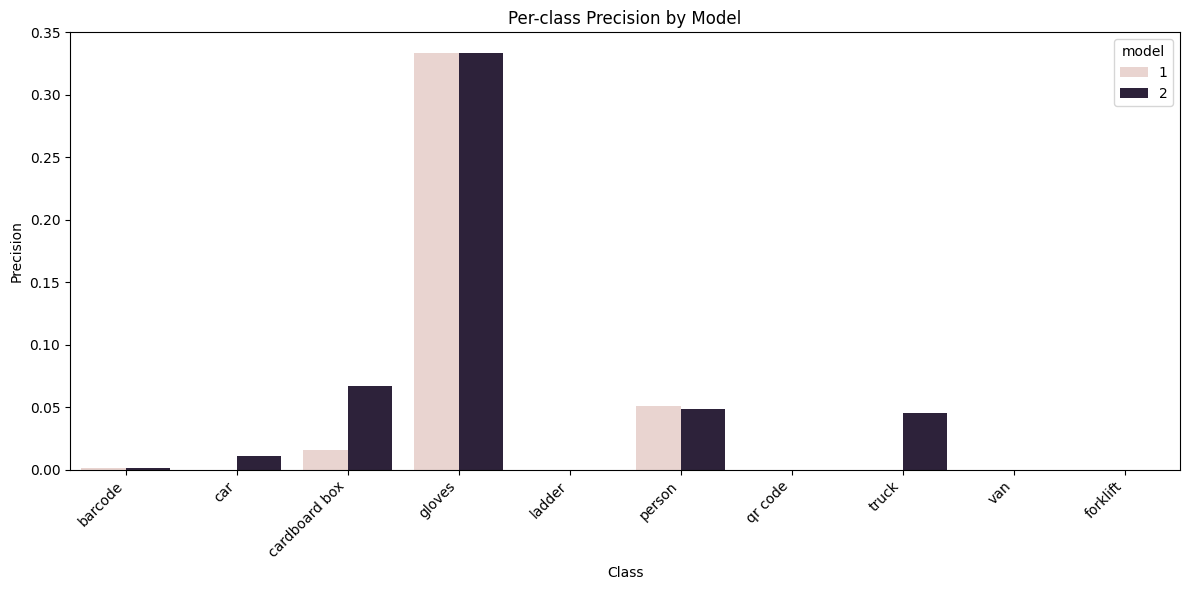

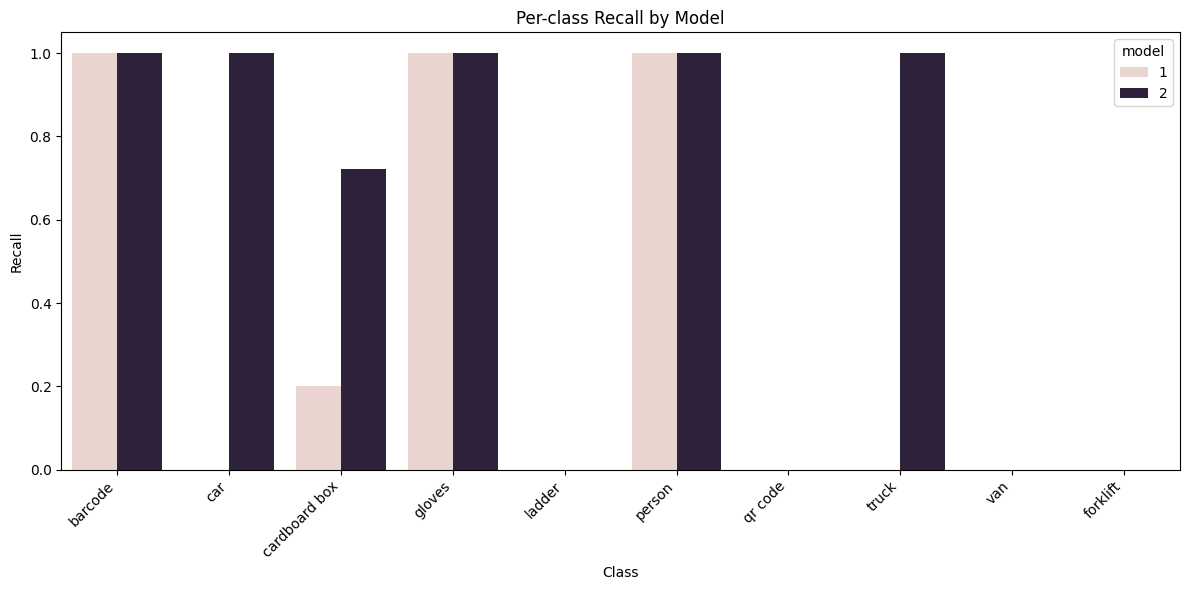

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=per_class_metrics,
    x="class_name", y="precision", hue="model"
)
plt.xticks(rotation=45, ha="right")
plt.title("Per-class Precision by Model")
plt.ylabel("Precision")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(
    data=per_class_metrics,
    x="class_name", y="recall", hue="model"
)
plt.xticks(rotation=45, ha="right")
plt.title("Per-class Recall by Model")
plt.ylabel("Recall")
plt.xlabel("Class")
plt.tight_layout()
plt.show()
